# 6.2 Evaluating Classification Models

Just as with regression models, we need ways to measure how good a classification model is. With regression models, the main metrics were MSE, RMSE, and MAE. With classification models, the main metrics are accuracy, precision, and recall. All of these metrics can be calculated on either the training data or the test data. We can also use cross validation to estimate the value of the metric on test data.

First, let's train a $9$-nearest neighbors model on the wine data, just so that we have a model to evaluate. The following code is copied from Section 5.1.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 5

reds = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/wines/reds.csv",
                   sep=";")
whites = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/wines/whites.csv", 
                     sep=";")

reds["color"] = "red"
whites["color"] = "white"

wines = pd.concat([reds, whites], 
                  ignore_index=True)

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# define the training data
X_train = wines[["volatile acidity", "total sulfur dioxide"]]
y_train = wines["color"]

# standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)

# fit the 9-nearest neighbors model
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train_sc, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

We will start by calculating training metrics, so we need predictions for the observations in the training data.

In [3]:
y_train_pred = model.predict(X_train_sc)
y_train_pred

array(['red', 'red', 'red', ..., 'white', 'white', 'white'], dtype=object)

# Metrics for Classification

Because the labels $y_i$ in a classification model are categorical, we cannot calculate the difference $y_i - \hat y_i$ between the actual and predicted labels, as we did for regression model. But we can determine if the predicted label $\hat y_i$ is correct ($\hat y_i = y_i$) or not ($\hat y_i \neq y_i$). For example, the **error rate** is defined to be:

$$ \textrm{error rate} = \textrm{proportion where } \hat y_i \neq y_i $$

With classification models, it is more common to report the performance in terms of a score, like **accuracy**, where a higher value is better:

$$ \textrm{accuracy} = \textrm{proportion where } \hat y_i = y_i $$

In [4]:
accuracy = (y_train_pred == y_train).mean()
accuracy

0.96059719870709559

If you ever forget how to calculate accuracy, you can have Scikit-Learn do it for you. It just needs to know the true labels and the predicted labels:

In [5]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_train_pred)

0.96059719870709559

The problem with accuracy is that it is sensitive to the initial distribution of classes in the training data. For example, if 99% of the wines in the data set were white, it would be trivial to obtain a model with 99% accuracy: the model could simply predict that every wine is white. Even though such a model has high overall accuracy, it is remarkably bad for red wines. We need some way to measure the "accuracy" of a model for a particular class.

Suppose we want to know the "accuracy" of our model for class $c$. There are two ways to interpret "accuracy for class $c$". Do we want to know the accuracy among the observations our model _predicted to be_ in class $c$ or the accuracy among the observations that _actually were_ in class $c$? The two options lead to two different notions of "accuracy" for class $c$: precision and recall.

The **precision** of a model for class $c$ is the proportion of observations predicted to be in class $c$ that actually were in class $c$. 

$$ \textrm{precision for class } c = \frac{\# \{i:  \hat y_i = c \textrm{ and } y_i = c\}}{\# \{i: \hat y_i = c \}}. $$

The **recall** of a model for class $c$ is the proportion of observations actually in class $c$ that were predicted to be in class $c$.

$$ \textrm{recall for class } c = \frac{\# \{i:  \hat y_i = c \textrm{ and } y_i = c\}}{\# \{i: y_i = c \}}. $$

Another way to think about precision and recall is in terms of true positives (TP) and false positives (FP). A "positive" is an observation that the model identified as belonging to class $c$ (i.e., $\hat y_i = c$). A true positive is one that actually was in class $c$ (i.e., $\hat y_i = c$ and $y_i = c$), while a false positive is one that was not (i.e., $\hat y_i = c$ and $y_i \neq c$). True and false _negatives_ are defined analogously.

In the language of positives and negatives, the precision is the proportion of positives that are true positives:
$$ \textrm{precision for class } c = \frac{TP}{TP + FP}, $$
while the recall is the proportion of observations in class $c$ that are positives (as opposed to negatives):
$$ \textrm{recall for class } c = \frac{TP}{TP + FN}. $$

The diagram below may help you to remember which numbers go in the numerator and denominator. The precision is the proportion of the red rectangle that is a TP, while the recall is the proportion of the red circle that is a TP.

![](precision_recall.png)

Let's calculate the precision and recall of our $9$-nearest neighbors model for the red "class":

In [6]:
true_positives = ((y_train_pred == "red") & (y_train == "red")).sum()

precision = true_positives / (y_train_pred == "red").sum()
recall = true_positives / (y_train == "red").sum()
    
precision, recall

(0.92634920634920637, 0.91244527829893685)

Again, you can have Scikit-Learn calculate precision and recall for you. These functions work similarly to `accuracy_score` above, except we have to explicitly specify the class for which we want the precision and recall. For example, to calculate the precision and recall of the model for red wines:

In [7]:
from sklearn.metrics import precision_score, recall_score

(precision_score(y_train, y_train_pred, pos_label="red"),
 recall_score(y_train, y_train_pred, pos_label="red"))

(0.92634920634920637, 0.91244527829893685)

It is important to specify `pos_label` because the precision and recall for other classes may be quite different:

In [8]:
(precision_score(y_train, y_train_pred, pos_label="white"),
 recall_score(y_train, y_train_pred, pos_label="white"))

(0.97155627793579846, 0.97631686402613316)

In general, there is a tradeoff between precision and recall. For example, you can improve recall by predicting more observations to be in class $c$, but this will hurt precision. To take an extreme example, a model that predicts that _every_ observation is in class $c$ has 100% recall, but its precision would likely be poor. To visualize this phenomenon, suppose we expand the positives from the dashed circle to the solid circle, as shown in the figure below, at right. This increases recall (because the circle now covers more of the red rectangle) but decreases precision (because the red rectangle now makes up a smaller fraction of the circle).

![](precision_recall_tradeoff.png)

Likewise, you can improve precision by predicting fewer observations to be in class $c$ (i.e., only the ones you are very confident about), but this will hurt recall. This is illustrated in the figure above, at left.

# Validation Accuracy, Precision, and Recall in Scikit-Learn

We calculated the training accuracy of our classifier above. However, test accuracy is more useful in most cases. We can estimate the test accuracy using cross validation. We will have Scikit-Learn carry out the cross validation for us, including the computation of the accuracy score on each held-out subsample. We simply have to specify the right `scoring=` method.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

pipeline = Pipeline([
    ("scaler", scaler),
    ("model", model)
])

cross_val_score(pipeline, X_train, y_train, 
                cv=10, scoring="accuracy")

array([ 0.94      ,  0.94615385,  0.94615385,  0.94307692,  0.95692308,
        0.96769231,  0.94923077,  0.94461538,  0.96918336,  0.94290123])

To obtain a single estimate of test accuracy from the 10 validation accuracies, we can take their average:

In [10]:
cross_val_score(pipeline, X_train, y_train, 
                cv=10, scoring="accuracy").mean()

0.95059307474279231

The validation accuracy is still high, but lower than the training accuracy. This makes sense because it is always harder to predict for future data than for current data.

Scikit-Learn can also calculate the precision and recall of a class $c$, but we need to manually convert the label to a binary label that is $1$ (or `True`) if the observation is in class $c$ and $0$ (or `False`) otherwise. For example, the following code calculates the validation _recall_ for red wines:

In [11]:
is_red_train = (y_train == "red")

cross_val_score(pipeline, X_train, is_red_train, 
                cv=10, scoring="recall").mean()

0.88495676100628928

To calculate the validation _precision_ for red wines, we just have to change the scoring method:

In [12]:
cross_val_score(pipeline, X_train, is_red_train, 
                cv=10, scoring="precision").mean()

0.91373083576211089

# F1 Score: Combining Precision and Recall

We have replaced accuracy by two numbers: precision and recall. We can combine the precision and recall into a single number, called the **F1 score**. 

The F1 score is defined to be the **harmonic mean** of the precision and the recall. That is, 

$$ \frac{1}{\text{F1 score}} = \frac{ \frac{1}{\text{precision}} + \frac{1}{\text{recall}}}{2}, $$

or equivalently, 

$$ \text{F1 score} = \frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}. $$

The harmonic mean of two numbers is always between the two numbers, but in general will be closer to the smaller number. For example, if precision is $90\%$ and recall is $10\%$, then the harmonic mean is 

$$ \text{F1 score} = \frac{2 \cdot 0.9 \cdot 0.1}{0.9 + 0.1} = 18\%. $$

This is a desirable property of F1 scores because we want to encourage models to have both high precision _and_ high recall. It is not sufficient for one of these to be high if the other is very low. In other words, we do not want to allow a high precision to cancel out a low recall, or vice versa.

The F1 score for red wines is:

In [13]:
2 * precision * recall / (precision + recall)

0.91934467548834276

We could have also asked Scikit-Learn calculate this for us. If we know the actual and predicted labels, we can use the `f1_score` function, which works similarly to `precision_score` and `recall_score` from above:

In [14]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred, pos_label="red")

0.91934467548834276

We can also have `cross_val_score` calculate and return the F1 scores on each held-out subsample:

In [15]:
cross_val_score(pipeline, X_train, is_red_train, 
                cv=10, scoring="f1")

array([ 0.87043189,  0.88888889,  0.89361702,  0.87707641,  0.90666667,
        0.93416928,  0.89589905,  0.88679245,  0.93710692,  0.88888889])

# Exercises

Exercises 1-3 ask you to use the Titanic data set (`https://raw.githubusercontent.com/dlsun/data-science-book/master/data/titanic.csv`) to train various classifiers.

**Exercise 1.** Train a 5-nearest neighbors model to predict whether or not a passenger on a Titanic survived, using their age, sex, and class as features. Calculate the _training_ accuracy, precision, and recall of this model for survivors.

In [16]:
titanic_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/titanic.csv")[["age", "pclass", "sex", "survived"]].dropna()
titanic_df.head()

,age,pclass,sex,survived
0,29.0000,1,female,1
1,0.9167,1,male,1
2,2.0000,1,female,0
3,30.0000,1,male,0
4,25.0000,1,female,0


In [17]:
X_train = titanic_df.drop("survived", axis=1).to_dict(orient="records")
y_train = titanic_df["survived"]

In [18]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier

vec = DictVectorizer(sparse=False)
scaler = RobustScaler()
model = KNeighborsClassifier(n_neighbors=5)

pipeline = Pipeline([
    ("vec", vec),
    ("scaler", scaler),
    ("model", model)
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vec', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=False)), ('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('model', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])

In [19]:
y_train_pred = pipeline.predict(X_train)
y_train_pred

array([1, 1, 1, ..., 0, 0, 0])

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy_score(y_train, y_train_pred)

0.84130019120458888

In [21]:
precision_score(y_train, y_train_pred, pos_label=1)

0.83206106870229013

In [22]:
recall_score(y_train, y_train_pred, pos_label=1)

0.76580796252927397

**Exercise 2.** Estimate the _test_ accuracy, precision, and recall of your model from Exercise 1 for survivors.

In [23]:
cross_val_score(pipeline, X_train, (y_train == 1), 
                cv=10, scoring="accuracy").mean()

0.76523996230306923

In [24]:
cross_val_score(pipeline, X_train, (y_train == 1), 
                cv=10, scoring="precision").mean() 

0.72139948947650145

In [25]:
cross_val_score(pipeline, X_train, (y_train == 1), 
                cv=10, scoring="recall").mean() 

0.68344407530454032

**Exercise 3.** You want to build a $k$-nearest neighbors model to predict where a Titanic passenger embarked, using their age, sex, and class. 

- What value of $k$ optimizes overall accuracy?
- What value of $k$ optimizes the F1 score for Southampton?

Does the same value of $k$ optimize accuracy and the F1 score?

In [26]:
titanic_df = pd.read_csv("https://raw.githubusercontent.com/dlsun/data-science-book/master/data/titanic.csv")[["age", "pclass", "sex", "embarked"]].dropna()
titanic_df.head()

,age,pclass,sex,embarked
0,29.0000,1,female,S
1,0.9167,1,male,S
2,2.0000,1,female,S
3,30.0000,1,male,S
4,25.0000,1,female,S


In [27]:
X_train = titanic_df.drop("embarked", axis=1).to_dict(orient="records")
y_train = titanic_df["embarked"]

In [28]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier

vec = DictVectorizer(sparse=False)
scaler = RobustScaler()
model = KNeighborsClassifier()

pipeline = Pipeline([
    ("vec", vec),
    ("scaler", scaler),
    ("model", model)
])

In [29]:
from sklearn.model_selection import GridSearchCV
pg = {
    "model__n_neighbors": range(1, 30, 1)
}

classifier_model = GridSearchCV(pipeline, pg, cv=10, scoring="accuracy")
classifier_model.fit(X_train, y_train)
print(classifier_model.best_params_, classifier_model.best_score_)

{'model__n_neighbors': 13} 0.689655172414


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [42]:
classifier_model = GridSearchCV(pipeline, pg, cv=10, scoring="f1")
classifier_model.fit(X_train, (y_train == "S"))
print(classifier_model.best_params_, classifier_model.best_score_)

{'model__n_neighbors': 13} 0.781056051943


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


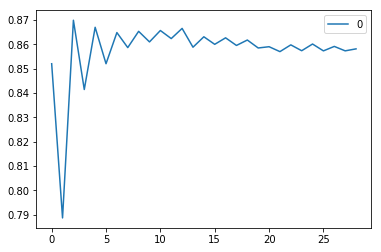

In [43]:
pd.DataFrame(classifier_model.cv_results_['mean_train_score']).plot()